# Some Transects
Plotting a few transects from MOM6 PanAnt simulation - mainly to check how they look on the boundary.

**Need a better way of masking out topo in density field**

Generally, these look OK to me ...

In [1]:
%matplotlib inline
import cosima_cookbook as cc
from dask.distributed import Client
import matplotlib.pyplot as plt

In [2]:
db='panant.db'
session=cc.database.create_session(db)

In [3]:
client = Client(n_workers=6)
client

Client Scheduler: tcp://127.0.0.1:39113 Dashboard: /proxy/8787/status,Cluster Workers: 6 Cores: 48 Memory: 202.48 GB


In [6]:
rhopot2 = cc.querying.getvar(expt='panan', variable='rhopot2', session=session, frequency='5 daily',
                          chunks={'xh':100,'yh':120}).isel(time=-1)
u = cc.querying.getvar(expt='panan', variable='u', session=session, frequency='5 daily',
                          chunks={'xq':100,'yh':120}).isel(time=-1)
v = cc.querying.getvar(expt='panan', variable='v', session=session, frequency='5 daily',
                           chunks={'xh':100,'yq':120}).isel(time=-1)

In [28]:
xloc = -80
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()

Text(0.5, 1.0, 'meridional velocity')

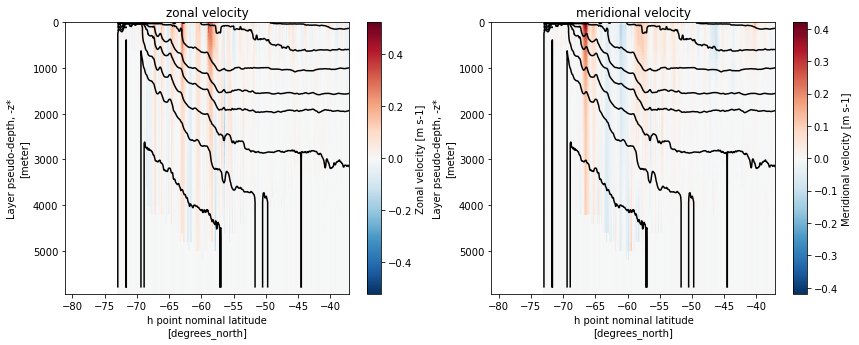

In [29]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])
rhopot2_slice.plot.contour(ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')
v_slice.plot(ax=ax[1])
rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')

In [20]:
xloc = 20
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()

Text(0.5, 1.0, 'meridional velocity')

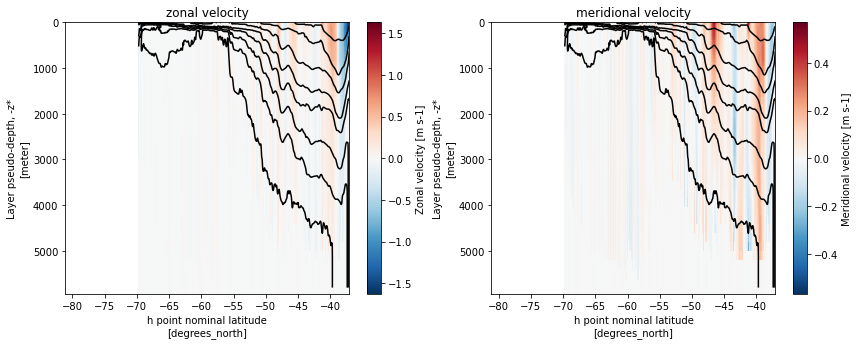

In [27]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])
rhopot2_slice.plot.contour(ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')
v_slice.plot(ax=ax[1])
rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')

In [30]:
xloc = 80
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()

Text(0.5, 1.0, 'meridional velocity')

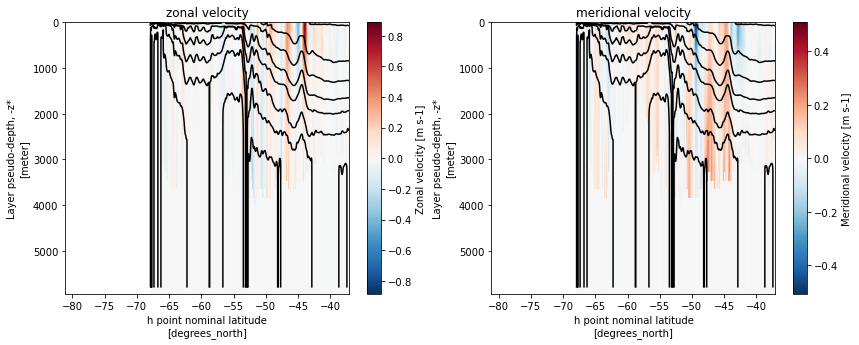

In [31]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])
rhopot2_slice.plot.contour(ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')
v_slice.plot(ax=ax[1])
rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')

In [33]:
xloc = -200
u_slice = u.sel(xq=xloc,method='nearest').load()
v_slice = v.sel(xh=xloc,method='nearest').load()
rhopot2_slice = rhopot2.sel(xh=xloc,method='nearest').load()

Text(0.5, 1.0, 'meridional velocity')

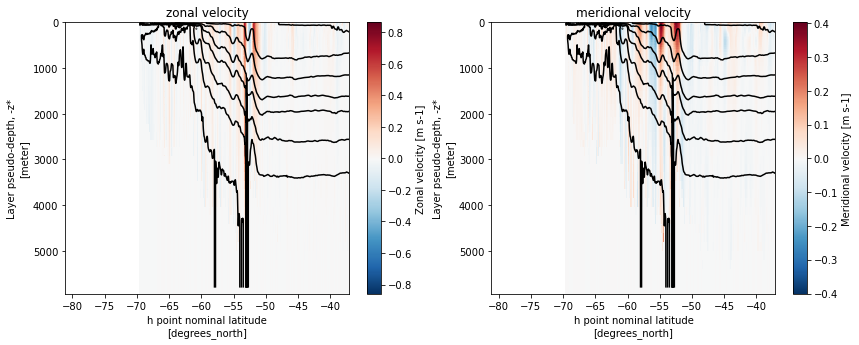

In [34]:
fig,ax = plt.subplots(1,2,figsize=(14,5))
u_slice.plot(ax=ax[0])
rhopot2_slice.plot.contour(ax=ax[0],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[0].invert_yaxis()
ax[0].set_title('zonal velocity')
v_slice.plot(ax=ax[1])
rhopot2_slice.plot.contour(ax=ax[1],colors='k',levels=[1035,1036,1036.5,1036.8,1036.9, 1037,1037.08,1037.14])
ax[1].invert_yaxis()
ax[1].set_title('meridional velocity')